### Задача uplift-моделирования

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("HW_data.csv")
df.rename(columns={'offer': 'treatment', "conversion": "target"}, inplace=True)
df.replace({"Buy One Get One": 1, "Discount": 1, "No Offer": 0}, inplace=True)
df.sample(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
1039,2,414.86,1,1,Rural,0,Phone,1,0
48463,12,411.31,1,1,Rural,1,Phone,0,0
42651,8,37.37,0,1,Urban,1,Web,1,0
43997,10,85.84,0,1,Urban,1,Web,0,0
40778,8,29.99,1,0,Surburban,1,Phone,0,1


In [17]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code','is_referral', 'channel']
treatment = 'treatment'
target = 'target'
cat_features=['zip_code','channel']

indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=0)

In [18]:
X_train = df.loc[indices_train, features]
y_train = df.loc[indices_train, target]
treat_train = df.loc[indices_train, treatment]
X_test = df.loc[indices_test, features]
y_test = df.loc[indices_test, target]
treat_test = df.loc[indices_test, treatment]
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [19]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import numpy as np

одна модель с признаком коммуникации

In [20]:
parameters_cb = {
     'n_estimators': [100, 150, 200, 600],
     'max_depth': np.arange(2, 10, 2),
 }
clf = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        cat_features=cat_features, random_state=0, silent=True
    ),
    param_distributions=parameters_cb,
    scoring='roc_auc',
    cv=5
)
clf.fit(X_train, y_train)
clf.best_params_

{'n_estimators': 150, 'max_depth': 2}

In [21]:
sm = SoloModel(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)
uplift_sm

array([0.06474648, 0.06334566, 0.06648938, ..., 0.03824635, 0.05260422,
       0.06960558])

In [22]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_10

0.08322145505689812

In [23]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_20

0.07571740199090574

In [24]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

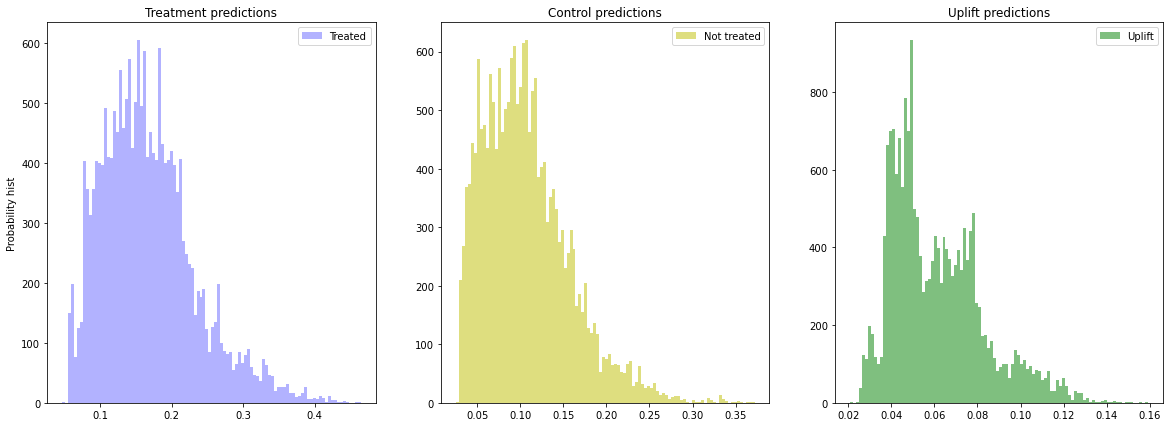

In [25]:

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [26]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.750695
1,is_referral,18.210243
2,history,15.739876
3,recency,14.276767
4,used_bogo,12.499108
5,used_discount,7.500295
6,zip_code,7.115304
7,channel,4.907712


трансформация классов

In [27]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [28]:
ct_score_10

0.07686406420583636

In [29]:

ct_score_20

0.06807883740936463

feature importance

In [30]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,36.358527
1,used_bogo,17.243842
2,zip_code,11.650731
3,channel,10.272304
4,recency,9.698686
5,used_discount,8.271899
6,is_referral,6.504012


2 независимые модели

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

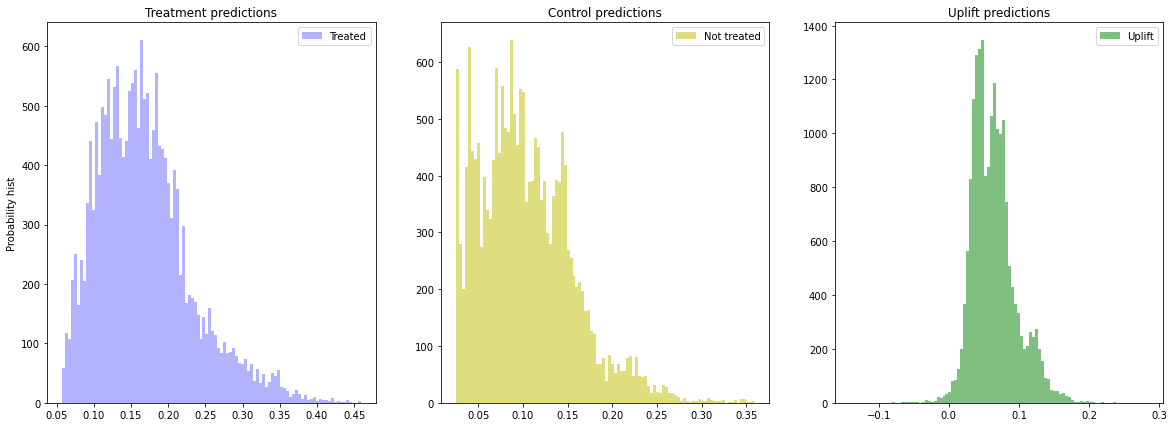

In [32]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True), 
    estimator_ctrl=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [33]:
tm_score_10

0.08575039587697814

In [34]:
tm_score_20

0.08177368809143418

feature importance для 1 модели

In [37]:
tm_fi_trmnt = pd.DataFrame({
    'feature_name': tm.estimator_trmnt.feature_names_,
    'feature_score': tm.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_trmnt

,feature_name,feature_score
0,used_bogo,23.475454
1,is_referral,19.255363
2,history,18.865121
3,recency,14.579694
4,used_discount,12.412655
5,zip_code,7.624304
6,channel,3.787408


Единая таблица сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [39]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.085750,0.081774
0,SoloModel,0.083221,0.075717
1,ClassTransformation,0.076864,0.068079
